In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
nside = 64
n_months = 7
mission_time_is_sec = 24 * 3600 * 30 * n_months
instrument = "MFT"
channel = "M1-140"
sampling = 1  # this replaces channelinfo.sampling_rate_hz

In [3]:
imo_version = "v1.3"
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
    random_seed=12345,
)

In [4]:
mft_file = sim.imo.query(
    "/releases/" + imo_version + "/satellite/" + instrument + "/instrument_info"
)
sim.set_scanning_strategy(
    imo_url="/releases/" + imo_version + "/satellite/scanning_parameters/"
)
instrumentinfo = lbs.InstrumentInfo(
    name=instrument,
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
)

instrumentinfo = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/v1.3/satellite/{instrument}/instrument_info"
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/"
    + imo_version
    + "/satellite/"
    + instrument
    + "/"
    + channel
    + "/channel_info",
    imo=imo,
)
hwp_radpsec = lbs.IdealHWP(
    instrumentinfo.hwp_rpm * 2 * np.pi / 60,
).ang_speed_radpsec

In [5]:
dets = []

for detname in (
    '001_003_030_00A_140_T',
    '001_003_030_00A_140_B',
):  # we choose the couple of detector at the MFT boresight
    det = lbs.DetectorInfo.from_imo(
        url='/releases/'+imo_version+'/satellite/'+ instrument+'/'+channel+'/'+detname+'/detector_info',
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)

## Fill tod and then build map

In [24]:
(obs,) = sim.create_observations(detectors=dets)


quaternion_buffer = np.zeros((obs.n_samples, 1, 4))
pointings = lbs.pointings.get_pointings(
    obs                 = obs,
    spin2ecliptic_quats = sim.spin2ecliptic_quats,
    bore2spin_quat      = instrumentinfo.bore2spin_quat,
    hwp                 = None,
    quaternion_buffer   = quaternion_buffer,
    )
del (quaternion_buffer, sim.spin2ecliptic_quats)

In [8]:
Mbsparams = lbs.MbsParameters(
    make_cmb         = True,
    make_fg          = False,
    gaussian_smooth  = True,
    bandpass_int     = False,
    maps_in_ecliptic = False,
    nside            = nside,
    units            = 'K_CMB',
    )

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=channelinfo,
)
maps = mbs.run_all()[0][channel]

[2023-10-24 16:09:09,593 INFO MPI#0000] generating and saving cmb simulations
[2023-10-24 16:09:09,624 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-10-24 16:09:09,625 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-10-24 16:09:09,671 INFO MPI#0000] Access data from /marconi_work/INF23_indark/nraffuzz/litebird/litebird_sim/litebird_sim/hwp_sys/examples/tutorial/cmb/0000/cmb_0000_date_231024.fits
[2023-10-24 16:09:09,674 INFO MPI#0000] NSIDE = 64
[2023-10-24 16:09:09,674 INFO MPI#0000] ORDERING = RING in fits file
[2023-10-24 16:09:09,675 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-10-24 16:09:09,746 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-10-24 16:09:09,747 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-10-24 16:09:09,750 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-10-24 16:09:09,750 INFO MPI#0000] -> fwhm is 0.000000 arcmin


***************** D
***************** D
***************** D


In [26]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=False,
)
print(f'mII = {hwp_sys.mII:.1f}, mQQ = {hwp_sys.mQQ:.1f}, mUU = {hwp_sys.mUU:.1f}') # diagonal terms
print(f'mIQ = {hwp_sys.mIQ:.1f}, mIU = {hwp_sys.mIU:.1f}, mQU = {hwp_sys.mQU:.1f}, mQI = {hwp_sys.mQI:.1f}, mUI = {hwp_sys.mUI:.1f}, mUQ = {hwp_sys.mUQ:.1f}') # off-diagonal terms

mII = 1.0, mQQ = 1.0, mUU = -1.0
mIQ = 0.0, mIU = 0.0, mQU = 0.0, mQI = 0.0, mUI = 0.0, mUQ = 0.0


In [27]:
hwp_sys.beta = 12 # degrees
hwp_sys.h1 = -0.08 # has to be negative
hwp_sys.z1 = 0.1+1j*0.01 # either real or complex
hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=False,
)

print(f'mII = {hwp_sys.mII:.3f}, mQQ = {hwp_sys.mQQ:.3f}, mUU = {hwp_sys.mUU:.3f}') # diagonal terms
print(f'mIQ = {hwp_sys.mIQ:.3f}, mIU = {hwp_sys.mIU:.3f}, mQU = {hwp_sys.mQU:.3f}, mQI = {hwp_sys.mQI:.3f}, mUI = {hwp_sys.mUI:.3f}, mUQ = {hwp_sys.mUQ:.3f}') # off-diagonal terms

mII = 0.928, mQQ = 0.918, mUU = -0.900
mIQ = -0.082, mIU = 0.092, mQU = 0.092, mQI = -0.072, mUI = -0.100, mUQ = 0.100


In [28]:
hwp_sys.fill_tod(
    obs=obs,
    pointings=pointings, # might be optional if point saved in obs
    hwp_radpsec=hwp_radpsec,
)
obs.tod *= 2.0  #

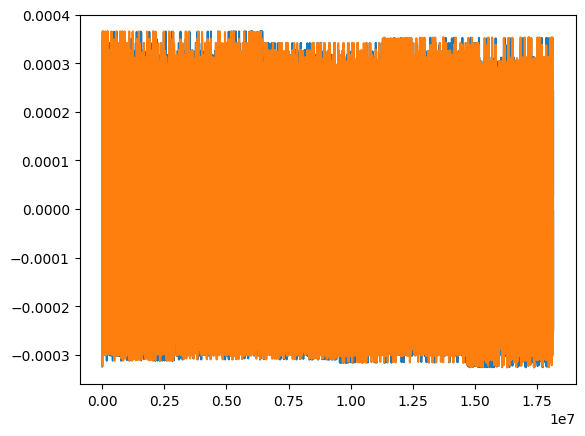

In [29]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])

In [30]:
m = lbs.make_binned_map(nside, [obs])

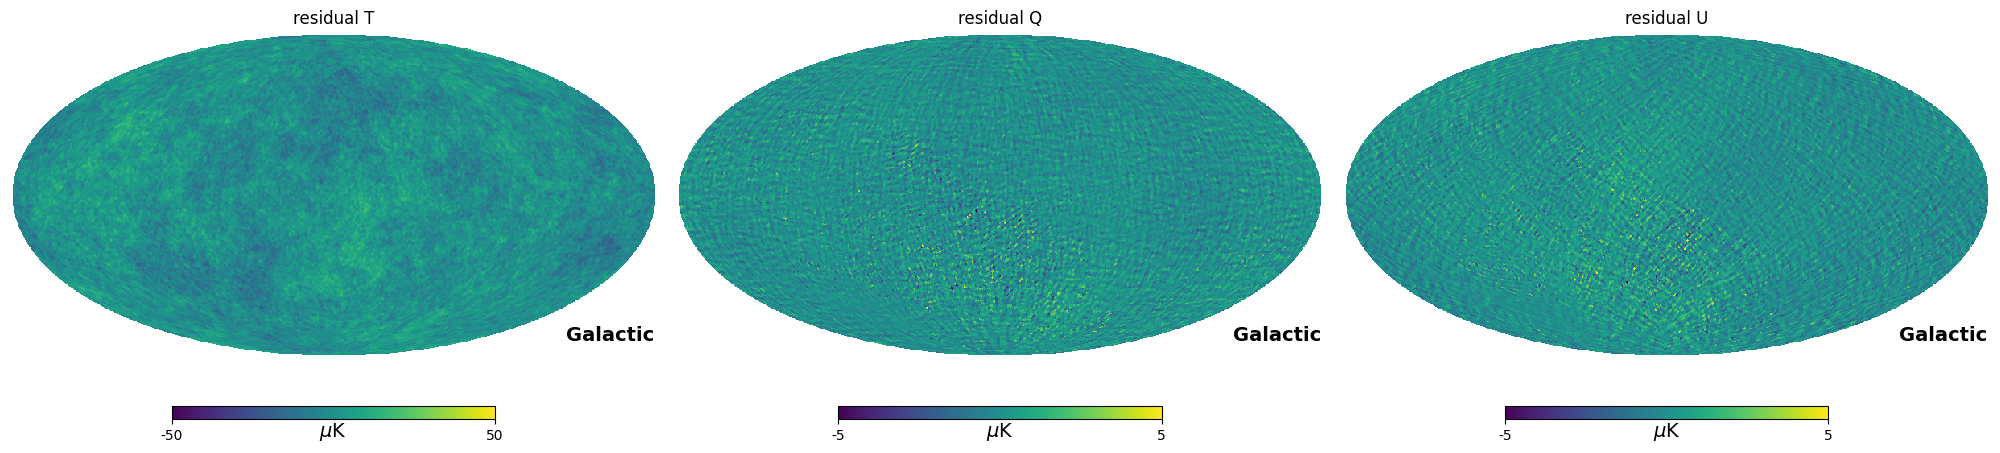

In [37]:
fig = plt.figure(figsize=(20, 10))
a = 50
hp.mollview((m.binned_map[0]- maps[0])*1e6 , unit='$\mu$K', sub=131, title="residual T", coord=["G"], min=-a, max=a) #
hp.mollview((m.binned_map[1]- maps[1])*1e6 , unit='$\mu$K', sub=132, title="residual Q", coord=["G"], min=-a*1e-1, max=a*1e-1) #
hp.mollview((m.binned_map[2]- maps[2])*1e6 , unit='$\mu$K', sub=133, title="residual U", coord=["G"], min=-a*1e-1, max=a*1e-1) #

## Built map on the fly

In [12]:
(obs,) = sim.create_observations(detectors=dets)

quaternion_buffer = np.zeros((obs.n_samples, 1, 4))
pointings = lbs.pointings.get_pointings(
    obs                 = obs,
    spin2ecliptic_quats = sim.spin2ecliptic_quats,
    bore2spin_quat      = instrumentinfo.bore2spin_quat,
    hwp                 = None,
    quaternion_buffer   = quaternion_buffer,
    )
del (quaternion_buffer, sim.spin2ecliptic_quats)

In [10]:
hwp_sys = lbs.HwpSys(sim)
# for tod filling, i.e. scanning
hwp_sys.beta = 12
hwp_sys.h1 = -0.08
hwp_sys.z1 = 0.1+1j*0.01
# for solver, i.e. map-making
hwp_sys.betas = 12
hwp_sys.h1s = -0.08
hwp_sys.z1s = 0.1+1j*0.01
hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=maps,
    integrate_in_band=False,
    integrate_in_band_solver=False,
    correct_in_solver=True,
    built_map_on_the_fly=True,
)

In [13]:
hwp_sys.fill_tod(obs=obs, pointings=pointings, hwp_radpsec=hwp_radpsec)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, int64)
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':
       No match.

During: typing of intrinsic-call at /marconi/home/userexternal/nraffuzz/.conda/envs/hwp_env/lib/python3.9/site-packages/litebird_sim/hwp_sys/hwp_sys.py (452)

File "../../../../../../../../marconi/home/userexternal/nraffuzz/.conda/envs/hwp_env/lib/python3.9/site-packages/litebird_sim/hwp_sys/hwp_sys.py", line 452:
def compute_atd_ata_for_one_detector(
    <source elided>
        Tterm, Qterm, Uterm = compute_TQUsolver_for_one_sample(
            mIIs=mIIs[i],
            ^


In [ ]:
m = hwp_sys.make_map([obs])

In [ ]:
fig = plt.figure(figsize=(20, 10))
a = 50
hp.mollview((m[0] - maps[0])*1e6, units='$\mu$K', sub=131, title="residual T", coord=["E", "G"], min=-a, max=a)
hp.mollview((m[1] - maps[1])*1e6, units='$\mu$K', sub=132, title="residual Q", coord=["E", "G"], min=-a*1e-1, max=a*1e-1)
hp.mollview((m[2] - maps[2])*1e6, units='$\mu$K', sub=133, title="residual U", coord=["E", "G"], min=-a*1e-1, max=a*1e-1)